#Regression

Regression refers to any machine learning or statistical method predict numerical data.

Here are some example questions:

* How much is the house going to sell for?
* What is the fuel efficiency of this car (given size, horsepower, etc.)?
* How many people will buy tickets to an event?

## Regression Algorithms

These are the two algorithms we'll look at today:

* Linear Regression (but not _Logistic Regression_)
* kNN

#How Delicious is Cheese?

As cheese ages, various chemical processes take place that determine the taste of the final product.

* 30 samples of mature cheddar cheese

Variables:
* Acetic: concentration of acetic acid
* H2S: concentration of hydogen sulfide
* Lactic: concentration of lactic acid

Labels:
* taste: subjective measure of taste (what we're trying to predict)

The labels are the true values according to experts.

We will learn from our labeled data so that we can make predictions on unlabeled data.

#Data

In [1]:
import pandas as pd

df = pd.read_csv('data/cheese.csv')
df = df.drop('Case', axis=1) #Case is an id number, we don't care about it.
df.head()

,taste,Acetic,H2S,Lactic
0,12.3,93.972295,22.988636,0.86
1,20.9,173.990378,154.934121,1.53
2,39.0,214.005133,229.981760,1.57
3,47.9,317.031139,1800.824690,1.81
4,5.6,105.953466,45.015191,0.99


#The regression problem

$$
y = f(X) + \epsilon
$$

* Find _*some function*_ $f$ that allows us to compute the target y using information in the matrix X.
* $\epsilon$ is our admission that our function may not fit perfectly.

# Choosing $f(X)$

One particularly straightforward choice assumes a linear relationship between the variables and the response.

##Linear Regression

$$
f(X) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... \beta_n x_n
$$

In fact, there are lots of cases where the relationships are linear (or can be transformed). So this is often a good choice.

# Linear Regression pictorally

Goal: find a line that fits the data.

We can visualize when we have just 1 feature.

Our data:

![Linear Regression](images/linear_regression.png)

A line fits the data nicely...

![Linear Regression](images/linear_regression_line.png)

Populating the interactive namespace from numpy and matplotlib


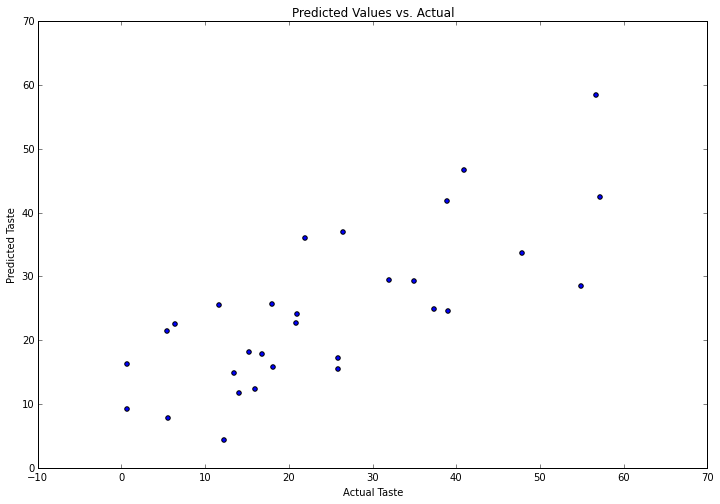

In [2]:
from sklearn.linear_model import LinearRegression
%pylab inline

X = df[['Acetic', 'H2S', 'Lactic']].values
y = df['taste'].values
ols = LinearRegression()
ols.fit(X, y)
predictions = ols.predict(X)

#Plot the actual vs. predicted
plt.figure(figsize=(12, 8))
plt.scatter(df.taste, predictions)
plt.title("Predicted Values vs. Actual")
plt.xlabel("Actual Taste")
plt.ylabel("Predicted Taste")

#How well are we doing?

Perfect model would put all points along the line y = x.

A measure of how well we're doing is _Root Mean Squared Error_.

#RMSE

$$
RMSE = \sqrt{\frac{1}{n}\sum_i\left(y_i - f(x_i)\right)}
$$


In [3]:
from sklearn.metrics import mean_squared_error

def rmse(target, predicted):
    return sqrt(mean_squared_error(target, predicted))

rmse(df.taste, predictions)

10.414106382577401

#What if our data isn't linear?

1. Make it linear via transformations!
2. Use another model!

#How would we know it isn't linear?

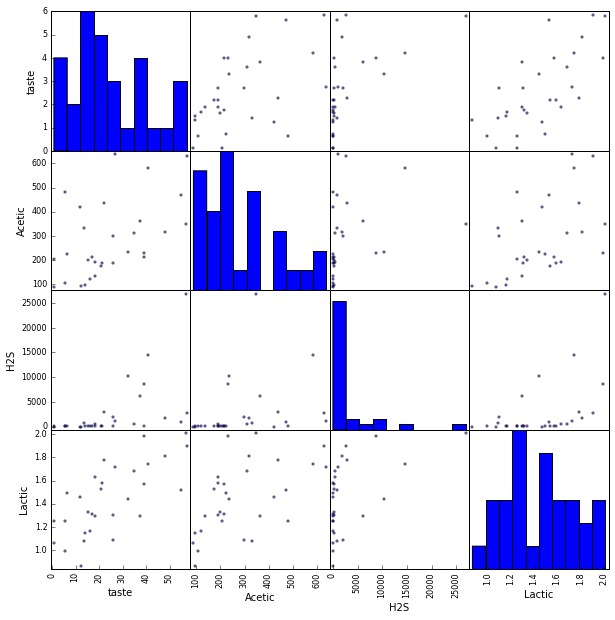

In [4]:
pd.tools.plotting.scatter_matrix(df, figsize=(10, 10))
plt.show()

#1. Make it linear via transformations.



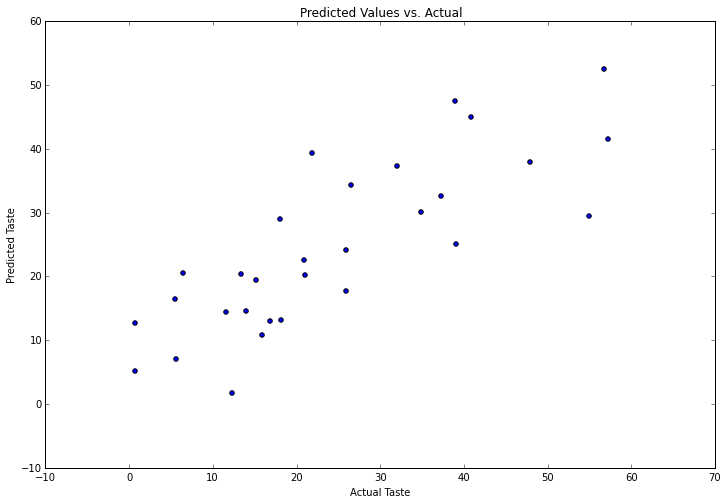

In [5]:
X_transform = pd.concat([df[['Acetic', 'H2S']].apply(np.log),
                         df[['Lactic']]], axis=1).values
ols_transform = LinearRegression().fit(X_transform, df.taste)
predictions_transform = ols_transform.predict(X_transform)

#Plot the actual vs. predicted
plt.figure(figsize=(12,8))
plt.scatter(df.taste, predictions_transform)
plt.title("Predicted Values vs. Actual")
plt.xlabel("Actual Taste")
plt.ylabel("Predicted Taste")

#So did we do better?

##Compare the scores

In [6]:
#Use RMSE instead.
print "          original:", rmse(predictions, y)
print "with log transform:", rmse(predictions_transform, y)

          original: 10.4141063826
with log transform: 9.43117363909


#Linear debrief
We were able to choose a transformation that made linear regression perform better, but there a some _potentially_ unsatisfying aspects about this:

1. What guarantee do we have that the function is the best?
2. What if the _correct_ function is one that we never even try?
3. What if we don't want to think about choosing a function?

# 2. Another model choice... KNN

For example, we could average the values of $y$ for the $k$ nearest points to any given $x_i$

$$
f(X) = \frac{1}{k}\sum_{i \in N_k(x_i)}y_i
$$

To predict, find the *k nearest datapoints* and average their values!

In [7]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()
knn_model.fit(X, y)
predictions_knn = knn_model.predict(X)

print "knn rmse:", rmse(predictions_knn, y)

knn rmse: 10.2134401648


#Data Science, it's easy
...to overfit.

#Restating our objective

Choose some $f$ that allows a good approximation

$$ y = f(X) + \epsilon $$ for *new data*.

![knn overfitting](images/knn.png)

#Predicting on unseen data

To know how well our model will perform on unseen data, we test it using data it hasn't been trained on.

Use tools in `sklearn.cross_validation`

In [8]:
from sklearn.cross_validation import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=10)
print train_X.shape, test_X.shape

(20, 3) (10, 3)


In [9]:
n_neighbors = range(1,20)
models = [KNeighborsRegressor(i).fit(train_X, train_y)
          for i in n_neighbors]
train_scores = [rmse(train_y, model.predict(train_X))
                for model in models]
test_scores = [rmse(test_y, model.predict(test_X))
               for model in models]

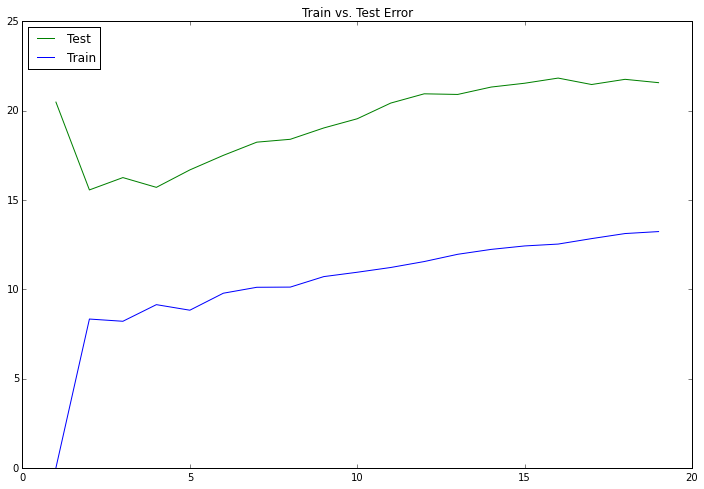

In [10]:
plt.figure(figsize=(12,8))
plt.plot(n_neighbors, test_scores, color='green', label='Test')
plt.plot(n_neighbors, train_scores, color='b', label='Train')
plt.title("Train vs. Test Error")
plt.legend(loc='upper left')

### Question

Why might what we've done _not really_ tell us what kind of RMSE to expect for new cheeses?

### Answer

If the testing set we've randomly chosen is somehow unusually _hard_ or _easy_.

### Solution

Use K-Fold Cross Validation.

* Many different test sets are chosen, and we consider the mean performance on all of those test sets.
* This gives us more confidence that our error represents our model performance, not the _difficulty_ of a single test set.

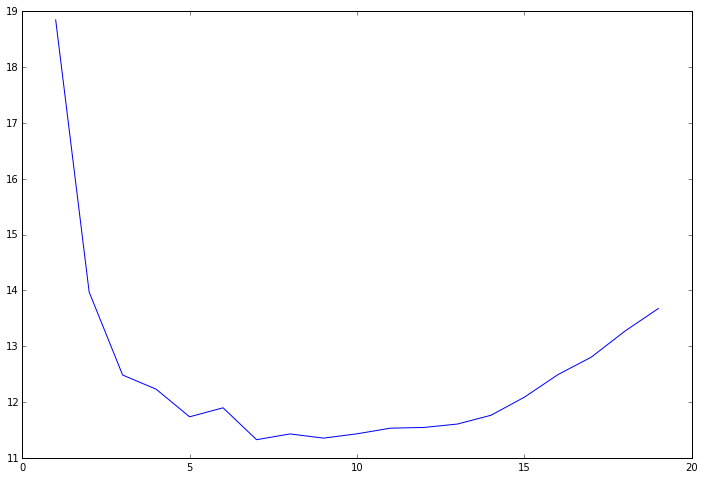

In [11]:
from sklearn.cross_validation import KFold

def kfold_cv_error(model, X, y, folds):
    test_error = []
    for train_index, test_index in folds:
        model.fit(X[train_index], y[train_index])
        predict = model.predict(X[test_index])
        fold_error = rmse(y[test_index], predict)
        test_error.append(fold_error)
    return np.mean(test_error)

folds = KFold(len(X), n_folds=10)
errors = []
for k in xrange(1, 20):
    err = kfold_cv_error(KNeighborsRegressor(n_neighbors=k), X, y, folds)
    errors.append(err)

plt.figure(figsize=(12,8))
plt.plot(range(1, 20), errors)

#Regression Exericise
* See the `regression_exercise.ipynb` file for a new dataset and some hints on how to work on a regression problem on your own.
